# Searchlight hyperalignment

In this Notebook, we will go through how to perform searchlight hyperalignment between brains.

## Preparations

In [1]:
%%capture
%pip install -U neuroboros

In [1]:
import numpy as np
import neuroboros as nb
from scipy.stats import zscore
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from hyperalignment.procrustes import procrustes
from hyperalignment.ridge import ridge
from hyperalignment.searchlight import searchlight_procrustes, searchlight_ridge

The Life dataset contains fMRI data (a) during watching the Life documentary and (b) during watching videos of various actions of various animals. See Nastase et al. ([2017](https://doi.org/10.1093/cercor/bhx138), [2018](https://doi.org/10.3389/fnins.2018.00316)) for more details.

This example focuses on the movie data (Life documentary).

In [2]:
dset = nb.Life()
sids = dset.subjects

In [3]:
dm1_train = dset.get_data(sids[0], 'life', [1, 2], 'l')
dm1_test = dset.get_data(sids[0], 'life', [3, 4], 'l')

dm2_train = dset.get_data(sids[1], 'life', [1, 2], 'l')
dm2_test = dset.get_data(sids[1], 'life', [3, 4], 'l')

## Response hyperalignment

In [4]:
radius = 10
sls, dists = nb.sls('l', radius, return_dists=True)

In [5]:
xfm_procr = searchlight_procrustes(dm1_train, dm2_train, sls, dists, radius)

In [6]:
xfm_ridge = searchlight_ridge(dm1_train, dm2_train, sls, dists, radius)

In [7]:
pred_procr = dm1_test @ xfm_procr
pred_ridge = dm1_test @ xfm_ridge

In [8]:
isc_orig = np.mean(zscore(dm1_test, axis=0) * zscore(dm2_test, axis=0), axis=0)
isc_procr = np.mean(zscore(pred_procr, axis=0) * zscore(dm2_test, axis=0), axis=0)
isc_ridge = np.mean(zscore(pred_ridge, axis=0) * zscore(dm2_test, axis=0), axis=0)

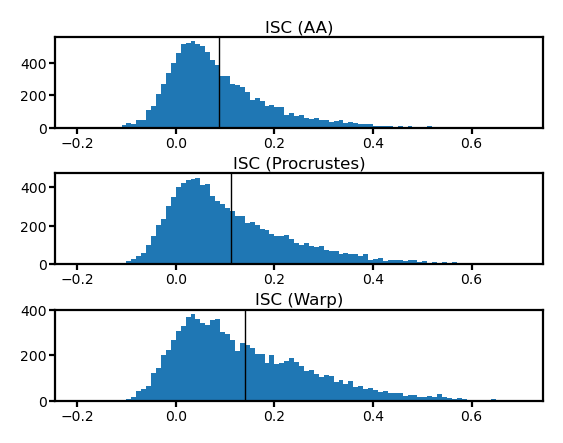

In [9]:
fig, axs = plt.subplots(3, 1, figsize=[_/2.54 for _ in [8, 6]], dpi=200)
for i, (ax, isc) in enumerate(zip(axs, [isc_orig, isc_procr, isc_ridge])):
    ax.hist(isc, np.linspace(-0.2, 0.7, 91))
    ax.axvline(isc.mean(), color='k', lw=0.5)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
    title = ['ISC (AA)', 'ISC (Procrustes)', 'ISC (Warp)'][i]
    ax.set_title(title, size=6, pad=2)
fig.subplots_adjust(hspace=0.5)
plt.show()

## Connectivity hyperalignment

In [10]:
mapper = nb.mapping('l', 'onavg-ico32', 'onavg-ico8', mask=True)
dm1_ico8 = dm1_train @ mapper
dm2_ico8 = dm2_train @ mapper
conn1 = 1 - cdist(dm1_ico8.T, dm1_train.T, 'correlation')
conn2 = 1 - cdist(dm2_ico8.T, dm2_train.T, 'correlation')

In [11]:
cha_procr = searchlight_procrustes(conn1, conn2, sls, dists, radius)

In [12]:
cha_ridge = searchlight_ridge(conn1, conn2, sls, dists, radius)

In [13]:
pred_procr_cha = dm1_test @ cha_procr
pred_ridge_cha = dm1_test @ cha_ridge

In [14]:
isc_procr_cha = np.mean(zscore(pred_procr_cha, axis=0) * zscore(dm2_test, axis=0), axis=0)
isc_ridge_cha = np.mean(zscore(pred_ridge_cha, axis=0) * zscore(dm2_test, axis=0), axis=0)

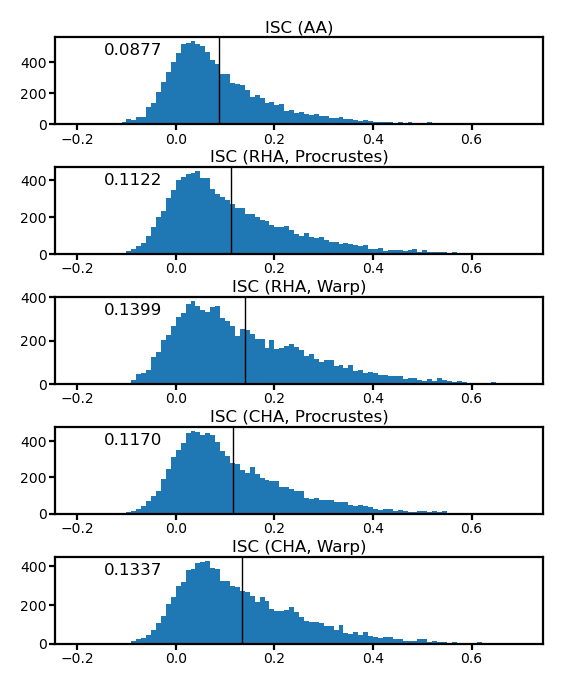

In [15]:
fig, axs = plt.subplots(5, 1, figsize=[_/2.54 for _ in [8, 10]], dpi=200)
for i, (ax, isc) in enumerate(zip(axs, [isc_orig, isc_procr, isc_ridge, isc_procr_cha, isc_ridge_cha])):
    ax.hist(isc, np.linspace(-0.2, 0.7, 91))
    ax.axvline(isc.mean(), color='k', lw=0.5)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
    title = ['ISC (AA)', 'ISC (RHA, Procrustes)', 'ISC (RHA, Warp)',
             'ISC (CHA, Procrustes)', 'ISC (CHA, Warp)'][i]
    ax.set_title(title, size=6, pad=2)
    ax.annotate(f'{isc.mean():.4f}', (0.1, 0.8), xycoords='axes fraction', size=6)
fig.subplots_adjust(hspace=0.5)
plt.show()

## Connectivity profiles

In [16]:
nt, nv = dm1_test.shape
xfms = [np.eye(nv), xfm_procr, xfm_ridge, cha_procr, cha_ridge]

targets = dm2_test @ mapper
conn2 = 1 - cdist(targets.T, dm2_test.T, 'correlation')

iscs = []
for xfm in xfms:
    aligned = dm1_test @ xfm
    targets = aligned @ mapper
    conn = 1 - cdist(targets.T, aligned.T, 'correlation')
    isc = np.mean(zscore(conn, axis=0) * zscore(conn2, axis=0), axis=0)
    iscs.append(isc)

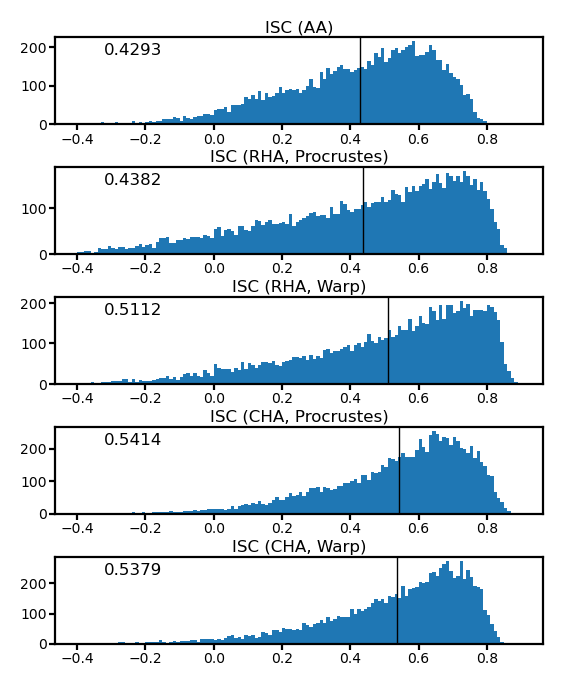

In [17]:
fig, axs = plt.subplots(5, 1, figsize=[_/2.54 for _ in [8, 10]], dpi=200)
for i, (ax, isc) in enumerate(zip(axs, iscs)):
    ax.hist(isc, np.linspace(-0.4, 0.9, 131))
    ax.axvline(isc.mean(), color='k', lw=0.5)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
    title = ['ISC (AA)', 'ISC (RHA, Procrustes)', 'ISC (RHA, Warp)',
             'ISC (CHA, Procrustes)', 'ISC (CHA, Warp)'][i]
    ax.set_title(title, size=6, pad=2)
    ax.annotate(f'{isc.mean():.4f}', (0.1, 0.8), xycoords='axes fraction', size=6)
fig.subplots_adjust(hspace=0.5)
plt.show()

In [18]:
nt, nv = dm1_test.shape
xfms = [np.eye(nv), xfm_procr, xfm_ridge, cha_procr, cha_ridge]

targets = dm2_test @ mapper
conn2 = 1 - cdist(targets.T, dm2_test.T, 'correlation')

cosines = []
for xfm in xfms:
    aligned = dm1_test @ xfm
    targets = aligned @ mapper
    conn = 1 - cdist(targets.T, aligned.T, 'correlation')
    norm = np.linalg.norm(conn, axis=0) * np.linalg.norm(conn2, axis=0)
    cos = np.sum(conn * conn2 / norm, axis=0)
    cosines.append(cos)

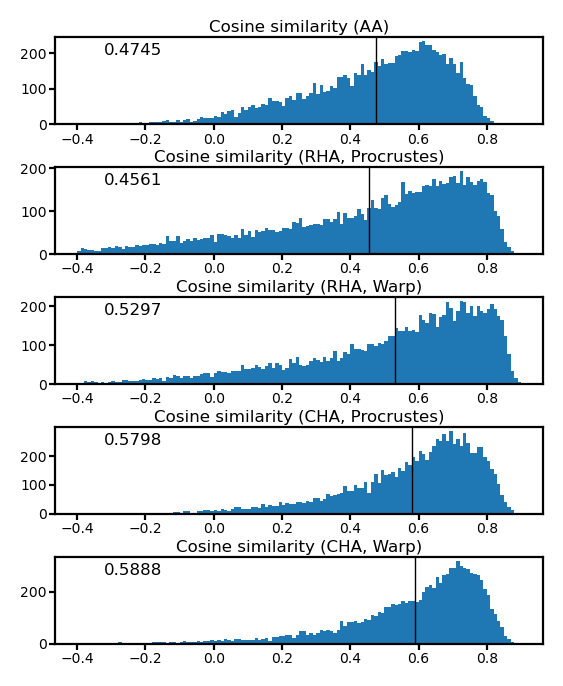

In [19]:
fig, axs = plt.subplots(5, 1, figsize=[_/2.54 for _ in [8, 10]], dpi=200)
for i, (ax, cos) in enumerate(zip(axs, cosines)):
    ax.hist(cos, np.linspace(-0.4, 0.9, 131))
    ax.axvline(cos.mean(), color='k', lw=0.5)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
    title = 'Cosine similarity ' + ['(AA)', '(RHA, Procrustes)', '(RHA, Warp)',
             '(CHA, Procrustes)', '(CHA, Warp)'][i]
    ax.set_title(title, size=6, pad=2)
    ax.annotate(f'{cos.mean():.4f}', (0.1, 0.8), xycoords='axes fraction', size=6)
fig.subplots_adjust(hspace=0.5)
plt.show()

## Using zscored connectivity profiles

In [20]:
cha_procr2 = searchlight_procrustes(
    zscore(conn1, axis=0), zscore(conn2, axis=0), sls, dists, radius)

In [21]:
cha_ridge2 = searchlight_ridge(
    zscore(conn1, axis=0), zscore(conn2, axis=0), sls, dists, radius)

In [22]:
pred_procr_cha2 = dm1_test @ cha_procr2
pred_ridge_cha2 = dm1_test @ cha_ridge2

In [23]:
isc_procr_cha2 = np.mean(
    zscore(pred_procr_cha2, axis=0) * zscore(dm2_test, axis=0), axis=0)
isc_ridge_cha2 = np.mean(
    zscore(pred_ridge_cha2, axis=0) * zscore(dm2_test, axis=0), axis=0)

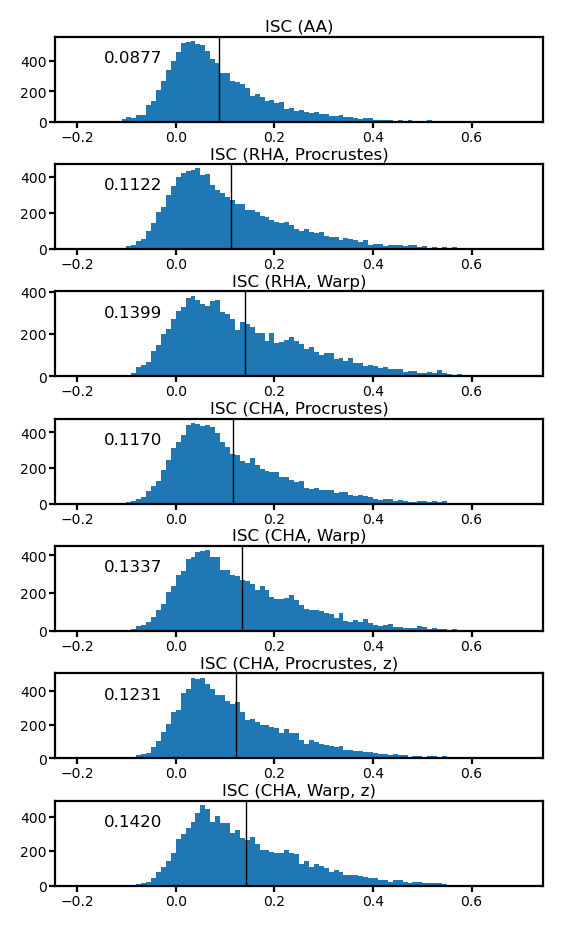

In [24]:
fig, axs = plt.subplots(7, 1, figsize=[_/2.54 for _ in [8, 14]], dpi=200)
iscs = [isc_orig, isc_procr, isc_ridge,
        isc_procr_cha, isc_ridge_cha, isc_procr_cha2, isc_ridge_cha2]
for i, (ax, isc) in enumerate(zip(axs, iscs)):
    ax.hist(isc, np.linspace(-0.2, 0.7, 91))
    ax.axvline(isc.mean(), color='k', lw=0.5)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
    title = ['ISC (AA)', 'ISC (RHA, Procrustes)', 'ISC (RHA, Warp)',
             'ISC (CHA, Procrustes)', 'ISC (CHA, Warp)',
             'ISC (CHA, Procrustes, z)', 'ISC (CHA, Warp, z)'][i]
    ax.set_title(title, size=6, pad=2)
    ax.annotate(f'{isc.mean():.4f}', (0.1, 0.7), xycoords='axes fraction', size=6)
fig.subplots_adjust(hspace=0.5)
plt.show()

In [25]:
nt, nv = dm1_test.shape
xfms = [np.eye(nv), xfm_procr, xfm_ridge, cha_procr, cha_ridge, cha_procr2, cha_ridge2]

targets = dm2_test @ mapper
conn2 = 1 - cdist(targets.T, dm2_test.T, 'correlation')

iscs = []
for xfm in xfms:
    aligned = dm1_test @ xfm
    targets = aligned @ mapper
    conn = 1 - cdist(targets.T, aligned.T, 'correlation')
    isc = np.mean(zscore(conn, axis=0) * zscore(conn2, axis=0), axis=0)
    iscs.append(isc)

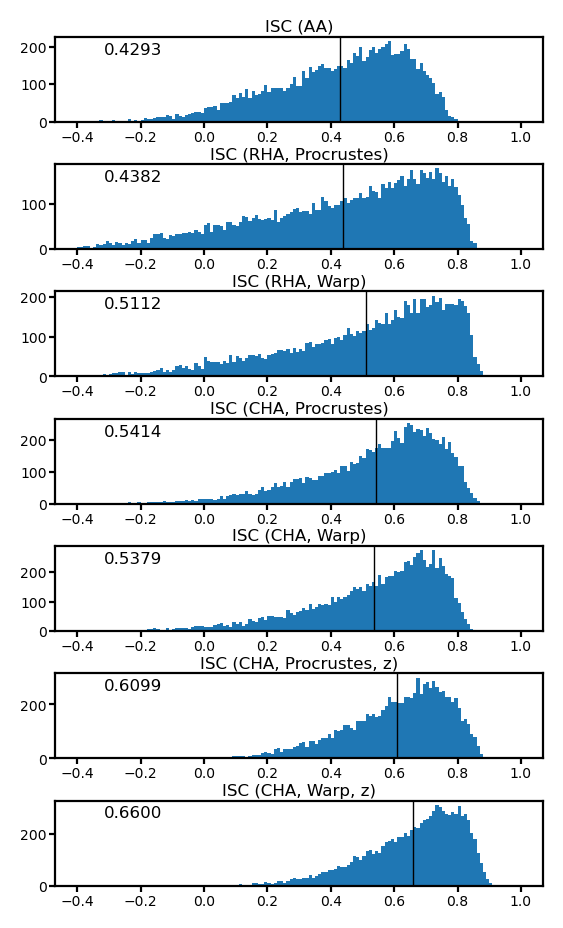

In [26]:
fig, axs = plt.subplots(7, 1, figsize=[_/2.54 for _ in [8, 14]], dpi=200)
for i, (ax, isc) in enumerate(zip(axs, iscs)):
    ax.hist(isc, np.linspace(-0.4, 1.0, 141))
    ax.axvline(isc.mean(), color='k', lw=0.5)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
    title = ['ISC (AA)', 'ISC (RHA, Procrustes)', 'ISC (RHA, Warp)',
             'ISC (CHA, Procrustes)', 'ISC (CHA, Warp)',
             'ISC (CHA, Procrustes, z)', 'ISC (CHA, Warp, z)'][i]
    ax.set_title(title, size=6, pad=2)
    ax.annotate(f'{isc.mean():.4f}', (0.1, 0.8), xycoords='axes fraction', size=6)
fig.subplots_adjust(hspace=0.5)
plt.show()